# week 5
## goals:
- use the API code or the downloaded borders
- input the actual boundaries of the MPAs
- for now: ignore when MPAs were implemented, and:
    - group by WDPAID
    - produce list of WDPAIDs by how much effort was contained 2012-2016 (the existing data set)

TODO:
- convert points to a geopandas dataframe including the geoseries column (these are points? boxes?)


## notes/learnings:
- just download 3GiB protected areas from protected planet!
- use geopandas to make a GeoDataFrame, the polygons are then a GeoSeries and we can ask .contains() or crosses() with the points (or boxes) of fishing effort
- only 5699 unique WDPAIDs
- need to construct southern latitude, western longitude, 100th degree box


### largest MPAs:
1. Marae Moana (Cook Islands) WDPAID = 555624907
2. Ross Sea Region (Ross Sea)
3. Papahanaumokuakea Marine National Monument (PMNM) [177, -160], [19, 32] 220201
4. Natural Park of the Coral Sea
5. Pacific Remote Islands (expanded) 400011
6. Coral Sea Marine Park
7. French Southern Territories Marine Reserve
8. Phoenix Islands wdpaid: 309888
9. Stellar Sea Lion Protection Areas (just Aleutian Islands 2015)


In [2]:
import numpy as np
import pandas
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pywdpa
import geopandas
import contextily as ctx
from shapely import geometry
import pretty_html_table

pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', 20)

In [3]:
# reads the downloaded WPDA polygon files
protected_areas = pandas.concat([
    geopandas.read_file("data/WDPA_WDOECM_wdpa_shp/WDPA_WDOECM_wdpa_shp0/WDPA_WDOECM_wdpa_shp-polygons.shp"),
    geopandas.read_file("data/WDPA_WDOECM_wdpa_shp/WDPA_WDOECM_wdpa_shp1/WDPA_WDOECM_wdpa_shp-polygons.shp"),
    geopandas.read_file("data/WDPA_WDOECM_wdpa_shp/WDPA_WDOECM_wdpa_shp2/WDPA_WDOECM_wdpa_shp-polygons.shp")
])
# filters for marine only (may want to change this to 1 or 2 (2 is marine only, 1 is mixed, 0 is terrestrial))
mpas = protected_areas[protected_areas["MARINE"] == "2"]
# delete the larger table - it's like 3 GiB and not needed past this point
del(protected_areas)

In [4]:
## Load the fishing hours data (this is kinda slow)
filenames = os.listdir('data/daily_csvs')

# this might be faster but the status printout is nice:
# points = pandas.concat([geopandas.read_file('data/daily_csvs/' + filename) for filename in filenames])

counted = 0
points = []
for filename in filenames:
    print(f'\r {filename} {counted}/{len(filenames)}', end='')
    points.append(pandas.read_csv('data/daily_csvs/' + filename,
                                      dtype={'lat_bin': 'int16',
                                             'lon_bin': 'int16',
                                             'mmsi': 'int32',
                                             'fishing_hours': 'float32'},
                                 parse_dates=['date']))
    counted += 1
points = pandas.concat(points) # deliberately overwriting points

 2013-12-20.csv 1826/1827

In [5]:
## Aggregate the points and bin them
points_aggregate = points.groupby(['lat_bin', 'lon_bin']).aggregate({'lat_bin': 'first', 'lon_bin': 'first', 'fishing_hours': 'sum'})
geopoints = geopandas.GeoDataFrame(
    points_aggregate,
    geometry=geopandas.points_from_xy(points_aggregate['lon_bin']*0.1, points_aggregate['lat_bin']*0.1)
).set_crs(epsg=4326)

In [17]:
# Produce ranked list of mpas by amount of effort inside their borders
# q - should we join by id or something first?

mpas_ = mpas[['WDPAID', 'NAME', 'geometry', 'STATUS_YR', 'REP_M_AREA', 'REP_AREA', 'NO_TAKE']]
joined_points = geopandas.sjoin(geopoints, mpas_, op='intersects')


In [18]:
joined_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 73041 entries, (-761, -1671) to (810, 209)
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   lat_bin        73041 non-null  int16   
 1   lon_bin        73041 non-null  int16   
 2   fishing_hours  73041 non-null  float32 
 3   geometry       73041 non-null  geometry
 4   index_right    73041 non-null  int64   
 5   WDPAID         73041 non-null  float64 
 6   NAME           73041 non-null  object  
 7   STATUS_YR      73041 non-null  int64   
 8   REP_M_AREA     73041 non-null  float64 
 9   REP_AREA       73041 non-null  float64 
 10  NO_TAKE        73041 non-null  object  
dtypes: float32(1), float64(3), geometry(1), int16(2), int64(2), object(2)
memory usage: 5.4+ MB


Text(0.5, 1.0, 'fishing hours 2012-2016 in 0.1 degree aggregate')

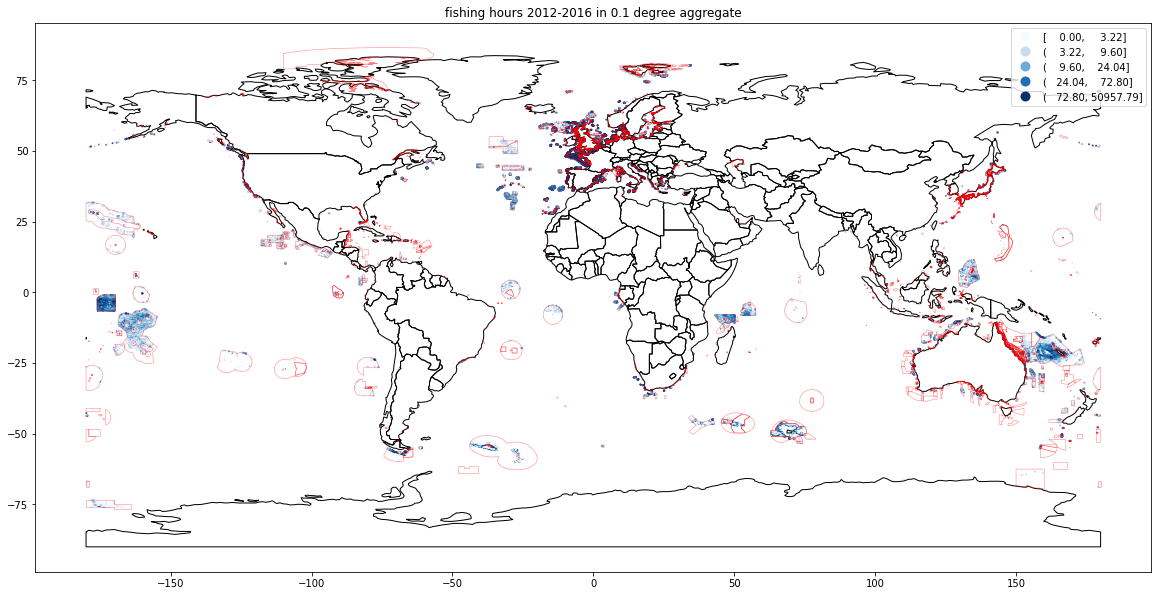

In [19]:
## Plot
ax = joined_points.plot(column='fishing_hours', figsize=(20, 30), markersize=1, cmap='Blues', scheme='quantiles', legend=True)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='None', edgecolor='black', ax=ax, )



marae = mpas[mpas["WDPAID"] == 555624907.0]
pmnm = mpas[mpas["WDPAID"] == 220201.0]

LINEWIDTH = 0.5
mpas.plot(ax=ax, color='None', edgecolor='red', linewidth=LINEWIDTH, alpha=0.5)

plt.title('fishing hours 2012-2016 in 0.1 degree aggregate')


In [9]:
def string_join(strings):
    base = strings.iloc[0] if strings.any() else ''
    for s in strings[1:]:
        base = base if s in base else base + '|' + s
    return base


joined_points_aggregate = joined_points.groupby(['WDPAID'], as_index=False).aggregate({
    'NAME': string_join,
    'fishing_hours': 'sum',
    'STATUS_YR': 'first',
    'REP_M_AREA': 'sum',
    'REP_AREA': 'sum',
    'NO_TAKE': string_join,
})



In [10]:
sorted_mpas = joined_points_aggregate.sort_values("fishing_hours", ascending=False)

In [11]:
since_2016 = sorted_mpas[sorted_mpas['STATUS_YR'] >= 2016]
since_2014 = sorted_mpas[sorted_mpas['STATUS_YR'] >= 2014]


reprint = True
if reprint:
    f = open("2016_or_later.html", "w")
    f.write(pretty_html_table.build_table(since_2016, 'blue_light'))
    f.close()

    f = open("2014_or_later.html", "w")
    f.write(pretty_html_table.build_table(since_2014, 'blue_light'))
    f.close()

    f = open("all_mpas_by_fishing_hours.html", "w")
    f.write(pretty_html_table.build_table(sorted_mpas, 'blue_light'))
    f.close()